# Model

In this class, we will develop a baseline for Task 2 using a subset of the lego dataset. We will model the task as an ordinal classification task.

In [2]:
import matplotlib.pyplot as plt, numpy as np, os, torch, random, cv2
from torch import nn
from torch.utils.data import DataLoader, Dataset
import torch.nn.functional as F
from torchvision import transforms, models
from sklearn.metrics import accuracy_score
from tqdm import tqdm



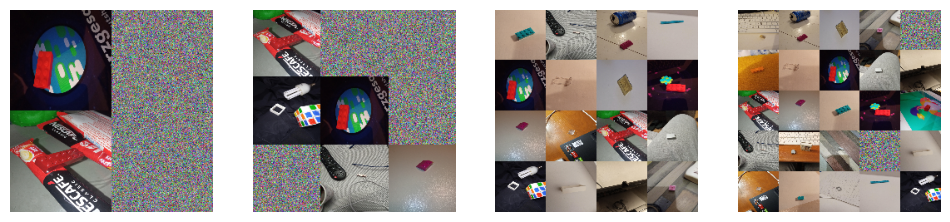

In [3]:
images_w_one_lego = []
for dirpath, dirnames, filenames in os.walk("photos"):
    for filename in filenames:
        # Check how many legos the image has
        n = int(dirpath.split(os.sep)[-1])
        if filename.endswith('.jpg'):
            if n == 1:
                images_w_one_lego.append(os.path.join(dirpath, filename))
       
# function to create a new image by stitching other n images together
def generate_LEGOs(images_list, number_legos, number_samples):
    random.seed(42)
    image_samples = random.sample(images_list, number_samples*number_legos)
    new_images = []

    for _ in range(number_samples):
        # Load the images
        images = [cv2.imread(image_samples.pop()) for _ in range(number_legos)]

        # Resize the images
        images = [cv2.resize(img, (512, 512)) for img in images]
        
        # Calculate the size of the grid
        side = int(np.ceil(np.sqrt(n)))
        
        # Create a new image with appropriate size
        new_image = np.zeros((512 * side, 512 * side, 3), dtype=np.uint8)
        
        # Append empty images if necessary
        while len(images) < side * side:
            # Append empty images with random color and noise
            empty_image = np.random.randint(0, 256, (512, 512, 3), dtype=np.uint8)
            # empty_image = cv2.GaussianBlur(empty_image, (51, 51), 0)
            images.append(empty_image)
        
        # Shuffle the images
        random.shuffle(images)

        # Stitch images in a grid without blending
        for i in range(side):
            for j in range(side):
                idx = i * side + j
                new_image[i * 512:(i + 1) * 512, j * 512:(j + 1) * 512, :] = images[idx]


        # for i in range(side):
        #     for j in range(side + 1):
        #         width_h = np.random.randint(30, 200)
        #         width_v = np.random.randint(30, 200)

        #         p = 512

        #         # Blend horizontally
        #         pixels_h = new_image[i * 512 - width_h//2:i * 512 + width_h//2, j*p:(j+1)*(p), :] + new_image[i * 512 - width_h//2:i * 512 + width_h//2, j*p:p*(j+1), :]
        #         np.random.shuffle(pixels_h)
        #         # Blend vertically
        #         pixels_v = new_image[j*p:p*(j+1), i * 512 - width_v//2:i * 512 + width_v//2, :] + new_image[j*p:p*(j+1), i * 512 - width_v//2:i * 512 + width_v//2, :]
        #         np.random.shuffle(pixels_v)
                                    
        #         new_image[i * 512 - width_h//2:i * 512 + width_h//2, j*p:p*(j+1), :] = pixels_h
        #         new_image[j*p:p*(j+1), i * 512 - width_v//2:i * 512 + width_v//2, :] = pixels_v

        # for i in range(1, side + 1):
        #     h_pixels = new_image[i * 512 - 50:(i + 1) * 512 + 50, :, :]
        #     v_pixels = new_image[:, i * 512 - 50:(i + 1) * 512 + 50, :]

        #     # Blur horizontally
        #     h_pixels = cv2.medianBlur(h_pixels, 21)

        #     # Blur vertically
        #     v_pixels = cv2.medianBlur(v_pixels, 21)

        #     new_image[i * 512 - 50:(i + 1) * 512 + 50, :, :] = h_pixels
        #     new_image[:, i * 512 - 50:(i + 1) * 512 + 50, :] = v_pixels


        # Resize the new image to 244x244
        new_image = cv2.resize(new_image, (244, 244))
        
        new_images.append(new_image)

    return new_images

n_legos = [2, 5, 16, 23]
new_images = []

for n in n_legos:
    ll = generate_LEGOs(images_w_one_lego, n, 1)
    new_images.append(ll[0])


# plot the new images
plt.figure(figsize=(12, 12))
for i, img in enumerate(new_images):
    plt.subplot(2, 4, i + 1)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.axis('off')

## Load dataset

In the Lego dataset, the images are organized into folders according to the number of legos. In this notebook, we will only consider images with up to 4 legos.

In [248]:
images_directory = "photos"

random.seed(42)

# Obtain names of images for training and validation
image_paths = []
num_legos = []

for dirpath, dirnames, filenames in os.walk(images_directory):
    for filename in filenames:
        # Check how many legos the image has
        n = int(dirpath.split(os.sep)[-1])
        if filename.endswith('.jpg'):
            image_paths.append(os.path.join(dirpath, filename))
            num_legos.append(n)
            if n != 1:
                # translate the image pixels to all sides
                image = cv2.imread(os.path.join(dirpath, filename))
                rows, cols, _ = image.shape
                for x in [-10, 5, 10]:
                    for y in [-10, 5, 10]:
                        M = np.float32([[1, 0, x], [0, 1, y]])
                        dst = cv2.warpAffine(image, M, (cols, rows))
                        new_image_path = os.path.join(dirpath, filename).replace(".jpg", f"_translated_{x}_{y}.jpg")
                        cv2.imwrite(new_image_path, dst)
                        image_paths.append(new_image_path)
                        num_legos.append(n)

                



print(f"Number of images list: {len(image_paths)}")
print(f"Number of legos list: {len(num_legos)}")

# plot histogram of number of images per lego
plt.hist(num_legos, bins=range(1, 32), align='mid')
plt.xlabel("Number of Legos")
plt.ylabel("Number of Images")
plt.show()

# balance the dataset
# get the number of images for the most common number of legos
max_num_legos = max(num_legos, key=num_legos.count)
print(f"Most common number of legos: {max_num_legos}")
max_num_legos_count = num_legos.count(max_num_legos)
print(f"Number of images with the most common number of legos: {max_num_legos_count}")

for i in range(1, 32):
    count = num_legos.count(i)
    num_ops = 0
    if count > 0:
        # calculate the number of operations to apply to each image with i legos to balance the dataset
        num_ops = (max_num_legos_count - count) // count
    print(f"Number of images with {i} legos: {count}, Number of operations: {num_ops}")
    for img in range(len(image_paths)):
        if num_legos[img] == i:
            new_image_paths = []
            new_num_legos = []
            image = cv2.imread(image_paths[img])
            for o in range(num_ops):
                rows, cols, _ = image.shape
                
                angle = random.randint(0, 360)

                image = cv2.rotate(image, r)
                new_image_path = image_paths[img].replace(".jpg", f"_rotated{r}.jpg")
                cv2.imwrite(new_image_path, image)
                new_image_paths.append(new_image_path)
                new_num_legos.append(i)

            







# # Using train test split gived by teacher in train_test_split.cv

# train_val_indexes = []
# train_indexes = []
# validation_indexes = []
# test_indexes = []

# # read .cv file and skip first line
# with open(train_test_split, "r") as f:
#     lines = f.readlines()[1:]
#     for line in lines:
#         line = line.split(",")
#         if line[1] == "0\n":
#             train_val_indexes.append(image_paths.index(line[0]))
#         else:
#             test_indexes.append(image_paths.index(line[0]))


# # Shuffle the train indexes to randomize the split
# random.shuffle(train_val_indexes)

# # Calculate the split point
# split_point = int(0.8 * len(train_val_indexes))

# # Split the train indexes into train and validation
# train_indexes, validation_indexes = train_val_indexes[:split_point], train_val_indexes[split_point:]

# print(f"Size of Train Data: {len(train_indexes)}")
# print(f"Size of Validation Data: {len(validation_indexes)}")
# print(f"Size of Test Data: {len(test_indexes)}")


# =============

image_paths = np.asarray(image_paths)
num_legos = torch.Tensor(num_legos).to(torch.int64)


# Randomly split data into train (0), validation (1) and test (2) sets
split = np.random.choice([0, 1, 2], len(image_paths), p=[0.8, 0.1, 0.1])

train_indexes = np.where(split == 0)[0]
validation_indexes = np.where(split == 1)[0]
test_indexes = np.where(split == 2)[0]

print(f"Size of Train Data: {len(train_indexes)}")
print(f"Size of Validation Data: {len(validation_indexes)}")
print(f"Size of Test Data: {len(test_indexes)}")

# =============

# indices = list(range(len(image_paths)))
# # print(indices)
# random.shuffle(indices)

# split_point = int(0.8 * len(indices))

# train_indexes, val_test_indexes = indices[:split_point], indices[split_point:]

# split_point = int(0.5 * len(val_test_indexes))

# validation_indexes, test_indexes = val_test_indexes[:split_point], val_test_indexes[split_point:]

# print(f"Size of Train Data: {len(train_indexes)}")
# print(f"Size of Validation Data: {len(validation_indexes)}")
# print(f"Size of Test Data: {len(test_indexes)}")

# image_paths = np.asarray(image_paths)
# num_legos = np.asarray(num_legos)

# for i in train_indexes:
#     print(f"{image_paths[i]}: {num_legos[i]}")

IndentationError: expected an indented block after 'if' statement on line 16 (2140031875.py, line 22)

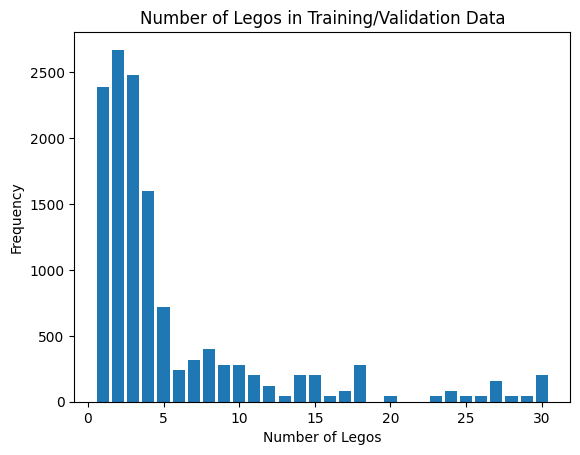

In [36]:
# Plot the distribution of the number of legos in the training data in a bar chart

plt.hist(num_legos, bins=range(1, 32), align='left', rwidth=0.8)
plt.title("Number of Legos in Training/Validation Data")
plt.xlabel("Number of Legos")
plt.ylabel("Frequency")
plt.show()

In [4]:
class LegosDataset(Dataset):
    def __init__(self, images_filenames, num_legos, transform=None):
        self.images_filenames = images_filenames
        self.transform = transform

        # Transform number of legos into one hot encoding
        self.labels = num_legos - 1

    def __len__(self):
        return len(self.images_filenames)

    def __getitem__(self, idx):
        image_filename = self.images_filenames[idx]
        label = self.labels[idx]

        # Read image
        image = cv2.imread(image_filename)

        # Convert from BGR to RGB
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        # Apply the same data augmentation to both input image and target mask
        if self.transform is not None:
            image = self.transform(image)

        return image, label

In [5]:
batch_size = 32
num_workers = 2

# Define transformations to be applied to data
transform = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Resize((224, 224)),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]
)

# Define datasets and dataloaders
train_dataset = LegosDataset(image_paths[train_indexes], num_legos[train_indexes], transform=transform)
validation_dataset = LegosDataset(image_paths[validation_indexes], num_legos[validation_indexes], transform=transform)
test_dataset = LegosDataset(image_paths[test_indexes], num_legos[test_indexes], transform=transform)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, num_workers=num_workers, shuffle=True)
validation_dataloader = DataLoader(validation_dataset, batch_size=batch_size, num_workers=num_workers, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=1, num_workers=num_workers, shuffle=False)

## Defining the model

Load a pre-trained convolutional neural network of your own choice from torchvision. Do not forget to change the last layer to match the number of classes (4)!

In [6]:
# Get cpu or gpu device for training.
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

# Load a pre-trained convolutional neural network of your own choice from torchvision. Do not forget to change the last layer to match the number of classes = 32.
model = models.resnet18(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, 32)

# Freeze all layers except the last one
for name, param in model.named_parameters():
    if "fc" not in name:
        param.requires_grad = False

model.to(device)

Using cpu device


/home/rubis/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/rubis/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

## Train the model

Define function to perform one iteration

In [4]:
def epoch_iter(model, dataloader, loss_fn, optimizer=None, train=True):
    if train:
        model.train()
    else:
        model.eval()

    running_loss = 0.0
    all_labels = []
    all_predictions = []

    for images, labels in tqdm(dataloader):
        images = images.to(device)
        labels = labels.to(device)

        if train:
            optimizer.zero_grad()

        with torch.set_grad_enabled(train):
            outputs = model(images)
            loss = loss_fn(outputs, labels)

            if train:
                loss.backward()
                optimizer.step()

        running_loss += loss.item()

        all_labels.extend(labels.cpu().numpy())
        all_predictions.extend(outputs.argmax(dim=1).detach().cpu().numpy())

    loss = running_loss / len(dataloader)
    accuracy = accuracy_score(all_labels, all_predictions)
    print("Predictions: ", all_predictions)

    return loss, accuracy

Define function to train a model

In [8]:
def train(model_name, model, num_epochs, train_dataloader, validation_dataloader, loss_fn, optimizer):
    train_history = {'loss': [], 'accuracy': []}
    val_history = {'loss': [], 'accuracy': []}

    best_val_loss = np.inf

    print("Start training...")

    for t in range(num_epochs):
        print(f"\nEpoch {t+1}")
        train_loss, train_acc = epoch_iter(model, train_dataloader, loss_fn, optimizer)
        print(f"Train loss: {train_loss:.3f} \t Train acc: {train_acc:.3f}")
        val_loss, val_acc = epoch_iter(model, validation_dataloader, loss_fn, train=False)
        print(f"Val loss: {val_loss:.3f} \t Val acc: {val_acc:.3f}")

        # save model when val loss improves
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            save_dict = {'model': model.state_dict(), 'optimizer': optimizer.state_dict(), 'epoch': t}
            torch.save(save_dict, model_name + '_best_model.pth')

        # save latest model
        save_dict = {'model': model.state_dict(), 'optimizer': optimizer.state_dict(), 'epoch': t}
        torch.save(save_dict, model_name + '_latest_model.pth')

        # save training history for plotting purposes
        train_history["loss"].append(train_loss)
        train_history["accuracy"].append(train_acc)

        val_history["loss"].append(val_loss)
        val_history["accuracy"].append(val_acc)

    print("Finished")
    return train_history, val_history


Define loss, optimizer and train the model. Remember that we will model this regression task problem as a classification problem when choosing the loss function!

In [9]:
# Define loss function for classification problem
loss_fn = nn.CrossEntropyLoss()

# Define optimizer
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)

num_epochs = 1

# Train the model
model_name = "LEGO Net"

train_history, val_history = train(model_name, model, num_epochs, train_dataloader, validation_dataloader, loss_fn, optimizer)


Start training...

Epoch 1


  0%|          | 0/334 [00:00<?, ?it/s]/home/rubis/.local/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/home/rubis/.local/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from Non

Predictions:  [30, 8, 10, 4, 8, 16, 4, 8, 8, 21, 4, 30, 10, 16, 28, 19, 5, 4, 28, 5, 5, 5, 8, 4, 9, 8, 4, 5, 4, 4, 8, 21, 16, 19, 5, 5, 21, 5, 8, 30, 30, 4, 5, 5, 19, 15, 21, 5, 8, 5, 30, 4, 5, 8, 5, 4, 7, 0, 8, 5, 9, 17, 19, 4, 28, 8, 4, 4, 4, 4, 8, 21, 27, 8, 4, 5, 5, 5, 30, 8, 5, 8, 28, 5, 5, 9, 21, 4, 8, 30, 4, 21, 30, 30, 8, 21, 5, 21, 10, 5, 29, 0, 19, 23, 4, 21, 7, 29, 0, 4, 9, 4, 10, 4, 8, 30, 8, 23, 5, 1, 9, 4, 16, 8, 4, 21, 10, 4, 21, 9, 8, 23, 8, 8, 0, 5, 28, 16, 9, 4, 21, 30, 19, 5, 0, 4, 4, 15, 4, 30, 9, 8, 17, 4, 30, 28, 5, 28, 0, 15, 4, 15, 8, 23, 16, 4, 1, 19, 29, 8, 4, 27, 21, 5, 9, 19, 4, 8, 15, 28, 0, 5, 28, 4, 4, 10, 28, 8, 15, 4, 4, 8, 4, 8, 8, 28, 29, 5, 4, 21, 15, 4, 21, 5, 19, 4, 0, 21, 1, 0, 8, 29, 5, 4, 8, 4, 10, 4, 15, 0, 16, 5, 5, 27, 4, 4, 4, 4, 10, 4, 0, 5, 0, 15, 23, 5, 8, 5, 14, 9, 8, 0, 3, 4, 0, 4, 1, 4, 1, 4, 15, 8, 0, 4, 28, 4, 0, 4, 1, 10, 30, 30, 23, 15, 30, 29, 3, 0, 9, 15, 8, 9, 4, 8, 29, 21, 4, 0, 10, 4, 8, 8, 28, 0, 19, 1, 4, 1, 28, 4, 8, 1, 21,

  0%|          | 0/42 [00:00<?, ?it/s]/home/rubis/.local/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/home/rubis/.local/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None

Predictions:  [1, 1, 0, 0, 2, 1, 2, 1, 2, 2, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 2, 1, 0, 2, 1, 0, 0, 2, 2, 1, 3, 2, 2, 2, 3, 1, 0, 2, 1, 1, 2, 0, 0, 2, 2, 0, 0, 0, 1, 2, 1, 0, 0, 2, 3, 2, 2, 1, 1, 2, 2, 2, 2, 2, 1, 2, 2, 0, 0, 0, 1, 2, 0, 2, 0, 1, 2, 1, 2, 0, 2, 0, 0, 0, 3, 3, 0, 1, 0, 2, 2, 2, 3, 2, 1, 0, 0, 2, 1, 2, 0, 1, 0, 2, 0, 0, 0, 2, 2, 3, 2, 0, 3, 2, 2, 2, 2, 4, 2, 2, 0, 2, 1, 1, 0, 1, 2, 2, 1, 2, 2, 2, 0, 2, 2, 2, 0, 2, 0, 2, 2, 0, 2, 0, 2, 1, 2, 0, 2, 2, 2, 2, 1, 1, 0, 0, 0, 0, 2, 0, 0, 1, 1, 2, 1, 2, 0, 2, 0, 0, 1, 2, 0, 2, 1, 3, 1, 3, 0, 1, 1, 0, 3, 0, 2, 0, 1, 0, 1, 2, 0, 1, 2, 1, 0, 1, 2, 0, 1, 2, 3, 2, 2, 1, 1, 1, 0, 0, 2, 0, 2, 2, 2, 3, 2, 2, 1, 2, 1, 3, 1, 1, 3, 1, 2, 0, 1, 2, 2, 1, 2, 0, 0, 0, 0, 2, 1, 1, 1, 2, 2, 1, 2, 2, 0, 2, 0, 2, 2, 3, 1, 0, 2, 3, 2, 0, 1, 2, 2, 2, 1, 0, 2, 0, 2, 2, 0, 2, 2, 0, 2, 2, 1, 0, 1, 0, 0, 2, 0, 2, 0, 1, 0, 0, 1, 1, 2, 0, 2, 2, 2, 2, 2, 1, 3, 2, 0, 3, 0, 2, 1, 2, 0, 2, 0, 0, 2, 3, 2, 1, 0, 2, 1, 3, 2, 1, 0, 0, 2, 0, 1, 1, 1, 0, 1, 3, 2, 2, 2

## Analyse training evolution

Plot loss and accuracy throughout training on train and validation data

In [10]:
def plotTrainingHistory(train_history, val_history):
    plt.subplot(2, 1, 1)
    plt.title('Cross Entropy Loss')
    plt.plot(train_history['loss'], label='train')
    plt.plot(val_history['loss'], label='val')
    plt.legend(loc='best')

    plt.subplot(2, 1, 2)
    plt.title('Classification Accuracy')
    plt.plot(train_history['accuracy'], label='train')
    plt.plot(val_history['accuracy'], label='val')

    plt.tight_layout()
    plt.legend(loc='best')
    plt.show()

In [11]:
# plotTrainingHistory(train_history, val_history)

## Test the model

Evaluate the model in the test set

In [7]:
model_name = "LEGO_resnet18"

loss_fn = nn.CrossEntropyLoss()

device = "cuda" if torch.cuda.is_available() else "cpu"

model = models.resnet18(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, 32)

model.to(device)

# Load the best model
checkpoint = torch.load(model_name + '_best_model.pth', map_location=device)

# Evaluate model on test data
model.load_state_dict(checkpoint['model'])

test_loss, test_acc = epoch_iter(model, test_dataloader, loss_fn, train=False)
print(f"Test loss: {test_loss:.3f} \t Test acc: {test_acc:.3f}")




/home/rubis/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/rubis/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
 83%|████████▎ | 1075/1302 [00:55<00:12, 17.84it/s]/home/rubis/.local/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor 

Predictions:  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3

In [12]:
def showErrors(model, dataloader, num_examples=10):    
    plt.figure(figsize=(15, 15))

    model.eval()
    
    for ind, (X, y) in enumerate(dataloader):
      if ind >= num_examples: break
      X, y = X.to(device), y.to(device)    
      pred = model(X)
      probs = F.softmax(pred, dim=1)
      final_pred = torch.argmax(probs, dim=1)

      plt.subplot(10, 10, ind + 1)
      plt.axis("off")
      plt.text(10, -1, "Label: " + str(y[0].item() + 1), fontsize=10, color='green') # correct
      plt.text(140, -1, "Pred: " + str(final_pred[0].item() + 1), fontsize=10, color='blue')  # predicted
      plt.imshow(X[0][0,:,:].cpu(), cmap='gray')
    plt.show()

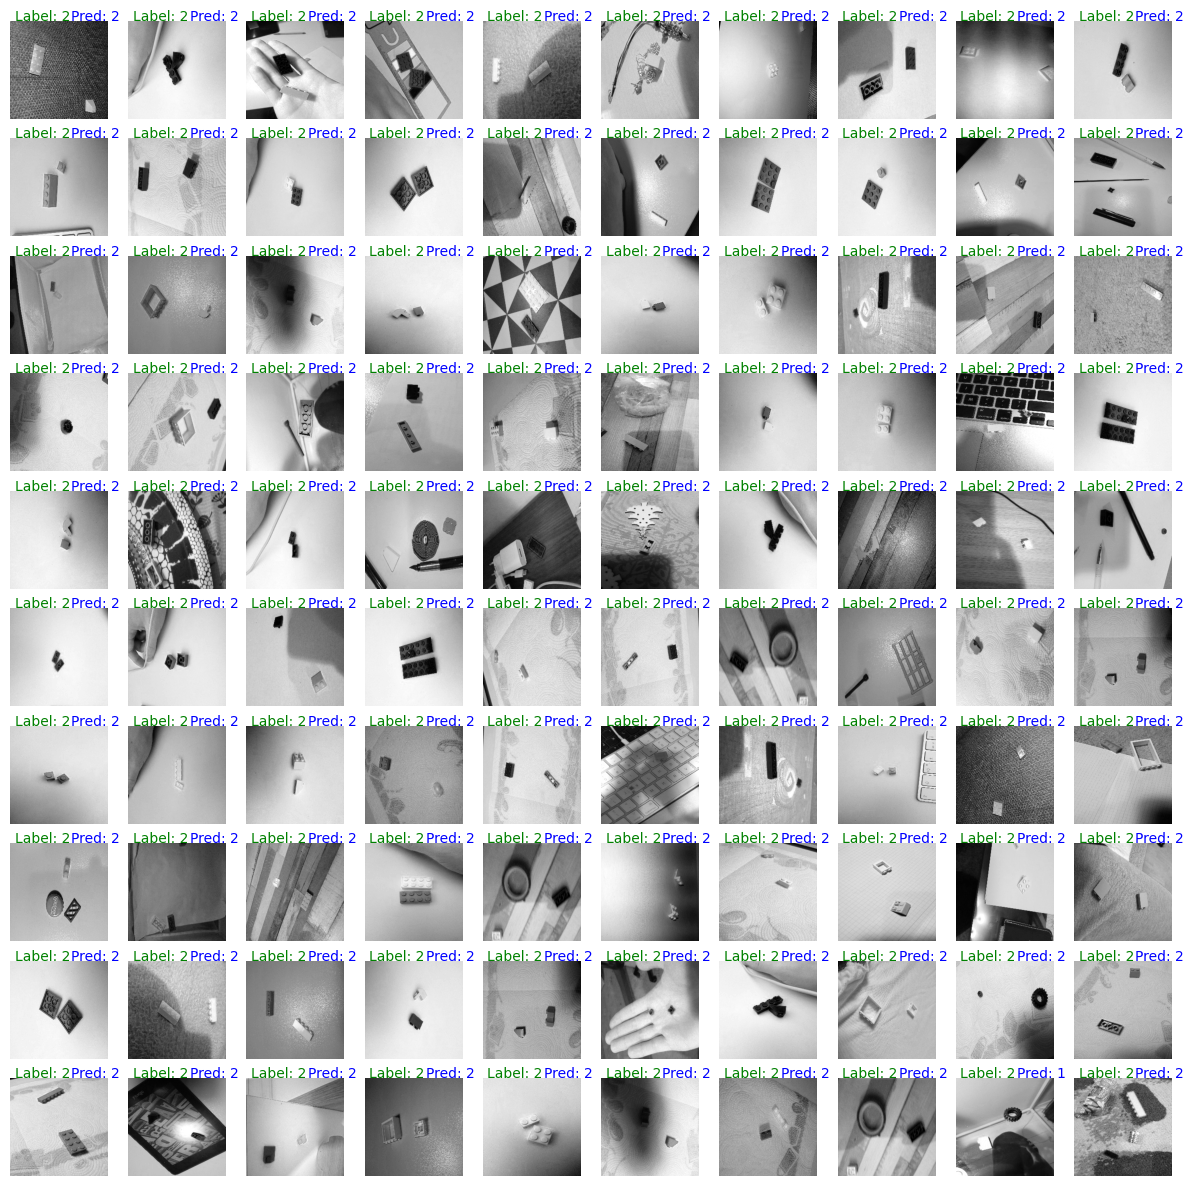

In [13]:
showErrors(model, test_dataloader, 100)

## Challenge

In transfer learning, we often replace the head of the model (fully-connected layers responsible for classification) to fit the task. However, these new layers are not pre-trained and thus they contain an error that is backpropagated through the pre-trained part of the network during training. We can avoid this through a training strategy that is divided into two steps:
* Freeze the pre-trained layers of the network so that their parameters are no longer updated during training and train only the head of the model
* Unfreeze these layers and train the network as a whole.

Implement this strategy and see the results!